In [1]:
!set PYTHONPATH=D:\SharedLinux_D\CPSC_597\Object_Detection_Expressions\research;D:\SharedLinux_D\CPSC_597\Object_Detection_Expressions\research\slim

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import keras
from keras.models import load_model
from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [3]:
# turn off tensorflow INFO (Debugging info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# append object_detection dir
sys.path.append("research/object_detection/..")
from object_detection.utils import ops as utils_ops
# od imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

OD_PATH = 'research/object_detection/'

In [4]:
# FUNCTIONS
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [5]:
# Additional Functions
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]


def one_hot_encode_to_char_list(arr, threshold=0.5, get_max=True):
    result = []
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((i, arr[i]))
    _max = []
    high = 0
    result = sorted(result, key=lambda x: x[1], reverse=True)
    if get_max:
        return result[-1]
    return result

In [6]:
# VARIABLES
MODEL_NAME = 'trained_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OD_PATH + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OD_PATH + "training/data/object-detection.pbtxt"

In [7]:
# Load tf model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


In [8]:
# Load label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [9]:
# DETECTION
PATH_TO_TEST_IMAGES_DIR = OD_PATH + "training/test_images/*"
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
print("Test Image paths: ")
for i in TEST_IMAGE_PATHS:
    print(i)
IMAGE_SIZE = (320, 320)

Test Image paths: 
research/object_detection/training/test_images\exp1.png
research/object_detection/training/test_images\exp2.png
research/object_detection/training/test_images\exp3.png
research/object_detection/training/test_images\exp4.png
research/object_detection/training/test_images\exp5.png
research/object_detection/training/test_images\exp6.png
research/object_detection/training/test_images\exp7.png
research/object_detection/training/test_images\exp8.png
research/object_detection/training/test_images\exp9.png


In [10]:
# Load cnn model and labels
#cnn = load_model("hasyv2model31.h5")
cnn = load_model("hasyv2model51.h5")

symbols = pd.read_csv("symbols.csv").drop(["Unnamed: 0"], axis=1)
symbols.head()

,latex,old_symbol,new_id
0,A,31,0
1,B,32,1
2,C,33,2
3,D,34,3
4,E,35,4


#### Note: Theres no data for `=` symbol in HASYv2 dataset. Therefore the predictions for `=` are all incorrect.

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp1.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44999066  xmin:  0.2513642  ymax:  0.53580046  xmax  0.31806386
left:  80.43654441833496  right:  101.78043365478516  top:  143.99701118469238  bottom  171.45614624023438
Top left point: ( 80 ,  143 ) and Bottom right point: ( 101 ,  171 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 90.37 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.97 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.68 %
Symbol_id: 42 , Latex: f , Confidence Score: 1.33 %


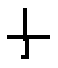

***************
Box: 
ymin:  0.44391948  xmin:  0.43839857  ymax:  0.54797727  xmax  0.50387985
left:  140.28754234313965  right:  161.24155044555664  top:  142.0542335510254  bottom  175.35272598266602
Top left point: ( 140 ,  142 ) and Bottom right point: ( 161 ,  175 )
CNN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 46.96 %
Symbol_id: 24 , Latex: Y , Confidence Score: 24.58 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 23.73 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.03 %


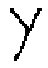

***************
Box: 
ymin:  0.44572115  xmin:  0.04157562  ymax:  0.55239964  xmax  0.14282936
left:  13.304198980331421  right:  45.70539474487305  top:  142.63076782226562  bottom  176.76788330078125
Top left point: ( 13 ,  142 ) and Bottom right point: ( 45 ,  176 )
CNN Predictions:
Symbol_id: 59 , Latex: x , Confidence Score: 71.12 %
Symbol_id: 92 , Latex: \times , Confidence Score: 18.84 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 6.49 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.09 %


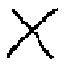

***************
Box: 
ymin:  0.46555385  xmin:  0.6373313  ymax:  0.51962435  xmax  0.72483474
left:  203.94601821899414  right:  231.94711685180664  top:  148.97723197937012  bottom  166.27979278564453
Top left point: ( 203 ,  148 ) and Bottom right point: ( 231 ,  166 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 37.35 %
Symbol_id: 100 , Latex: ] , Confidence Score: 10.68 %
Symbol_id: 94 , Latex: \div , Confidence Score: 9.32 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 7.18 %
Symbol_id: 106 , Latex: //) , Confidence Score: 4.3 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.16 %
Symbol_id: 105 , Latex: //( , Confidence Score: 3.52 %
Symbol_id: 104 , Latex: = , Confidence Score: 2.04 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.89 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.74 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.69 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.6 %
Symbol_id: 45 , Latex: i , Confidence Score: 1

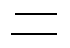

***************
Box: 
ymin:  0.45615444  xmin:  0.86647  ymax:  0.53164816  xmax  0.97814864
left:  277.27039337158203  right:  313.00756454467773  top:  145.96941947937012  bottom  170.12741088867188
Top left point: ( 277 ,  145 ) and Bottom right point: ( 313 ,  170 )
CNN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 71.11 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.98 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 4.82 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.46 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.48 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.46 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 1.09 %


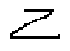

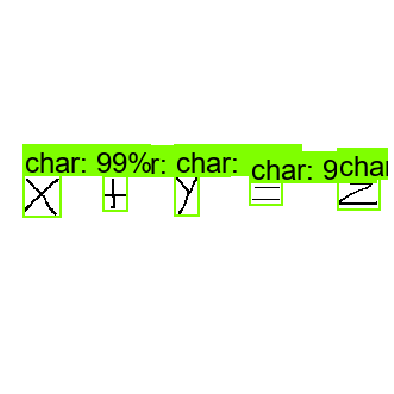

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp2.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44999066  xmin:  0.2513642  ymax:  0.53580046  xmax  0.31806386
left:  80.43654441833496  right:  101.78043365478516  top:  143.99701118469238  bottom  171.45614624023438
Top left point: ( 80 ,  143 ) and Bottom right point: ( 101 ,  171 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 90.37 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.97 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.68 %
Symbol_id: 42 , Latex: f , Confidence Score: 1.33 %


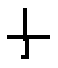

***************
Box: 
ymin:  0.44393703  xmin:  0.43836713  ymax:  0.547993  xmax  0.5039252
left:  140.27748107910156  right:  161.25606536865234  top:  142.05985069274902  bottom  175.35776138305664
Top left point: ( 140 ,  142 ) and Bottom right point: ( 161 ,  175 )
CNN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 46.96 %
Symbol_id: 24 , Latex: Y , Confidence Score: 24.58 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 23.73 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.03 %


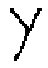

***************
Box: 
ymin:  0.44572115  xmin:  0.04157562  ymax:  0.55239964  xmax  0.14282936
left:  13.304198980331421  right:  45.70539474487305  top:  142.63076782226562  bottom  176.76788330078125
Top left point: ( 13 ,  142 ) and Bottom right point: ( 45 ,  176 )
CNN Predictions:
Symbol_id: 59 , Latex: x , Confidence Score: 71.12 %
Symbol_id: 92 , Latex: \times , Confidence Score: 18.84 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 6.49 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.09 %


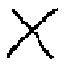

***************
Box: 
ymin:  0.45240363  xmin:  0.85019463  ymax:  0.51617825  xmax  0.95621365
left:  272.06228256225586  right:  305.9883689880371  top:  144.76916313171387  bottom  165.17704010009766
Top left point: ( 272 ,  144 ) and Bottom right point: ( 305 ,  165 )
CNN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.14 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 18.26 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.1 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.82 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.19 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.6 %


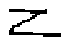

***************
Box: 
ymin:  0.46917805  xmin:  0.64042324  ymax:  0.5163214  xmax  0.71498626
left:  204.9354362487793  right:  228.79560470581055  top:  150.13697624206543  bottom  165.2228546142578
Top left point: ( 204 ,  150 ) and Bottom right point: ( 228 ,  165 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 58.77 %
Symbol_id: 94 , Latex: \div , Confidence Score: 8.0 %
Symbol_id: 100 , Latex: ] , Confidence Score: 7.61 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.69 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.07 %
Symbol_id: 19 , Latex: T , Confidence Score: 2.02 %
Symbol_id: 8 , Latex: I , Confidence Score: 1.68 %
Symbol_id: 99 , Latex: [ , Confidence Score: 1.35 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.32 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.25 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.06 %


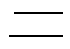

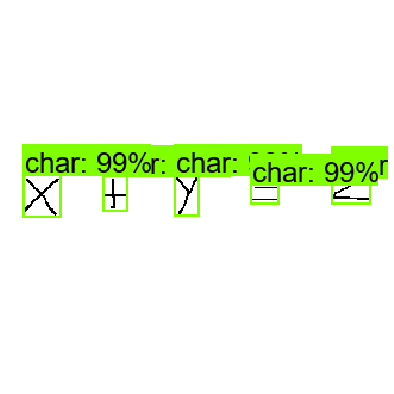

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp3.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4499312  xmin:  0.2511184  ymax:  0.5404139  xmax  0.31803358
left:  80.35788536071777  right:  101.77074432373047  top:  143.97798538208008  bottom  172.93245315551758
Top left point: ( 80 ,  143 ) and Bottom right point: ( 101 ,  172 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 81.72 %
Symbol_id: 94 , Latex: \div , Confidence Score: 6.9 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 5.49 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 3.36 %


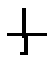

***************
Box: 
ymin:  0.43770596  xmin:  0.44458184  ymax:  0.5455529  xmax  0.5088599
left:  142.26618766784668  right:  162.8351593017578  top:  140.06590843200684  bottom  174.57693099975586
Top left point: ( 142 ,  140 ) and Bottom right point: ( 162 ,  174 )
CNN Predictions:
Symbol_id: 59 , Latex: x , Confidence Score: 15.72 %
Symbol_id: 79 , Latex: > , Confidence Score: 15.4 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 14.59 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 10.93 %
Symbol_id: 60 , Latex: y , Confidence Score: 10.79 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.57 %
Symbol_id: 24 , Latex: Y , Confidence Score: 5.85 %
Symbol_id: 92 , Latex: \times , Confidence Score: 5.29 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 4.53 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.58 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.03 %


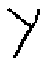

***************
Box: 
ymin:  0.44578376  xmin:  0.041571718  ymax:  0.5526384  xmax  0.14257307
left:  13.302949666976929  right:  45.62338352203369  top:  142.65080451965332  bottom  176.84429168701172
Top left point: ( 13 ,  142 ) and Bottom right point: ( 45 ,  176 )
CNN Predictions:
Symbol_id: 59 , Latex: x , Confidence Score: 71.12 %
Symbol_id: 92 , Latex: \times , Confidence Score: 18.84 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 6.49 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.09 %


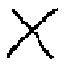

***************
Box: 
ymin:  0.45217615  xmin:  0.8501176  ymax:  0.51627517  xmax  0.95638514
left:  272.0376396179199  right:  306.0432434082031  top:  144.69636917114258  bottom  165.2080535888672
Top left point: ( 272 ,  144 ) and Bottom right point: ( 306 ,  165 )
CNN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.14 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 18.26 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.1 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.82 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.19 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.6 %


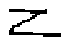

***************
Box: 
ymin:  0.47009808  xmin:  0.63697815  ymax:  0.5169529  xmax  0.7198405
left:  203.8330078125  right:  230.34896850585938  top:  150.4313850402832  bottom  165.42491912841797
Top left point: ( 203 ,  150 ) and Bottom right point: ( 230 ,  165 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 44.9 %
Symbol_id: 100 , Latex: ] , Confidence Score: 12.58 %
Symbol_id: 94 , Latex: \div , Confidence Score: 7.36 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.41 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 3.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.6 %
Symbol_id: 99 , Latex: [ , Confidence Score: 2.25 %
Symbol_id: 8 , Latex: I , Confidence Score: 2.22 %
Symbol_id: 19 , Latex: T , Confidence Score: 2.04 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.51 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.41 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.31 %


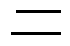

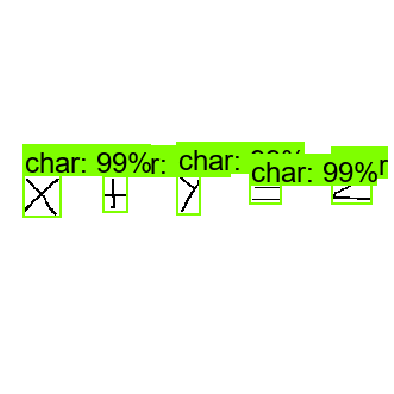

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp4.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45295438  xmin:  0.24826379  ymax:  0.5347422  xmax  0.31809932
left:  79.44441318511963  right:  101.79178237915039  top:  144.94540214538574  bottom  171.11749649047852
Top left point: ( 79 ,  144 ) and Bottom right point: ( 101 ,  171 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 86.72 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 7.39 %
Symbol_id: 42 , Latex: f , Confidence Score: 2.93 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.28 %


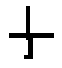

***************
Box: 
ymin:  0.43742734  xmin:  0.4424059  ymax:  0.54521877  xmax  0.51202756
left:  141.56989097595215  right:  163.84881973266602  top:  139.97674942016602  bottom  174.4700050354004
Top left point: ( 141 ,  139 ) and Bottom right point: ( 163 ,  174 )
CNN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 25.24 %
Symbol_id: 60 , Latex: y , Confidence Score: 21.69 %
Symbol_id: 25 , Latex: Z , Confidence Score: 12.3 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 6.99 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.78 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.72 %
Symbol_id: 92 , Latex: \times , Confidence Score: 4.18 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.65 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.44 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.74 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.46 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.2 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.12 %


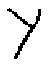

***************
Box: 
ymin:  0.45217615  xmin:  0.8501176  ymax:  0.51627517  xmax  0.95638514
left:  272.0376396179199  right:  306.0432434082031  top:  144.69636917114258  bottom  165.2080535888672
Top left point: ( 272 ,  144 ) and Bottom right point: ( 306 ,  165 )
CNN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.14 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 18.26 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.1 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.82 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.19 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.6 %


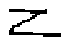

***************
Box: 
ymin:  0.43817922  xmin:  0.024549946  ymax:  0.5463091  xmax  0.1036338
left:  7.855982780456543  right:  33.1628155708313  top:  140.21735191345215  bottom  174.81891632080078
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.45 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.2 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.01 %


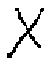

***************
Box: 
ymin:  0.47009808  xmin:  0.63697815  ymax:  0.5169529  xmax  0.7198405
left:  203.8330078125  right:  230.34896850585938  top:  150.4313850402832  bottom  165.42491912841797
Top left point: ( 203 ,  150 ) and Bottom right point: ( 230 ,  165 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 44.9 %
Symbol_id: 100 , Latex: ] , Confidence Score: 12.58 %
Symbol_id: 94 , Latex: \div , Confidence Score: 7.36 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.41 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 3.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.6 %
Symbol_id: 99 , Latex: [ , Confidence Score: 2.25 %
Symbol_id: 8 , Latex: I , Confidence Score: 2.22 %
Symbol_id: 19 , Latex: T , Confidence Score: 2.04 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.51 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.41 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.31 %


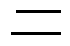

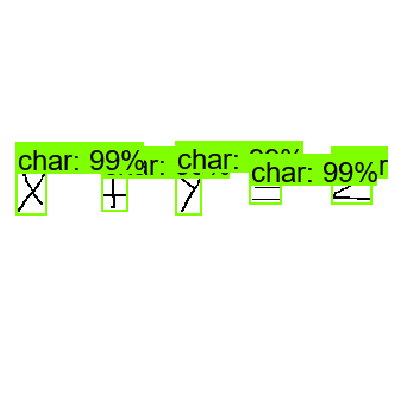

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp5.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44711676  xmin:  0.24510165  ymax:  0.5312586  xmax  0.31201696
left:  78.43252658843994  right:  99.84542846679688  top:  143.0773639678955  bottom  170.00274658203125
Top left point: ( 78 ,  143 ) and Bottom right point: ( 99 ,  170 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 31.57 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 19.09 %
Symbol_id: 42 , Latex: f , Confidence Score: 18.22 %
Symbol_id: 94 , Latex: \div , Confidence Score: 11.54 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 7.02 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.05 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.75 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.47 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.17 %
Symbol_id: 54 , Latex: r , Confidence Score: 1.07 %


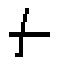

***************
Box: 
ymin:  0.43786198  xmin:  0.43819687  ymax:  0.54542625  xmax  0.51501364
left:  140.22299766540527  right:  164.80436325073242  top:  140.1158332824707  bottom  174.5363998413086
Top left point: ( 140 ,  140 ) and Bottom right point: ( 164 ,  174 )
CNN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 21.26 %
Symbol_id: 79 , Latex: > , Confidence Score: 19.75 %
Symbol_id: 24 , Latex: Y , Confidence Score: 12.57 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 10.34 %
Symbol_id: 59 , Latex: x , Confidence Score: 10.12 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 9.84 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 3.08 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.2 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.47 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.46 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.36 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.12 %


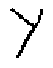

***************
Box: 
ymin:  0.45217615  xmin:  0.8501176  ymax:  0.51627517  xmax  0.95638514
left:  272.0376396179199  right:  306.0432434082031  top:  144.69636917114258  bottom  165.2080535888672
Top left point: ( 272 ,  144 ) and Bottom right point: ( 306 ,  165 )
CNN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.14 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 18.26 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.1 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.82 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.19 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.6 %


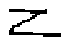

***************
Box: 
ymin:  0.4701  xmin:  0.6369825  ymax:  0.51694953  xmax  0.71980214
left:  203.83440017700195  right:  230.33668518066406  top:  150.4319953918457  bottom  165.4238510131836
Top left point: ( 203 ,  150 ) and Bottom right point: ( 230 ,  165 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 44.9 %
Symbol_id: 100 , Latex: ] , Confidence Score: 12.58 %
Symbol_id: 94 , Latex: \div , Confidence Score: 7.36 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.41 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 3.73 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.6 %
Symbol_id: 99 , Latex: [ , Confidence Score: 2.25 %
Symbol_id: 8 , Latex: I , Confidence Score: 2.22 %
Symbol_id: 19 , Latex: T , Confidence Score: 2.04 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.51 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.41 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.31 %


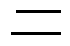

***************
Box: 
ymin:  0.43925992  xmin:  0.02273547  ymax:  0.54577696  xmax  0.10554023
left:  7.2753506898880005  right:  33.772873878479004  top:  140.56317329406738  bottom  174.64862823486328
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.49 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.46 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.48 %


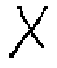

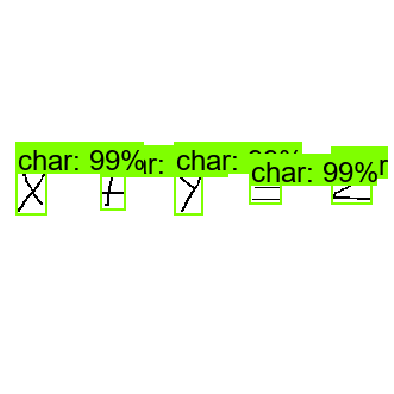

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp6.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4471263  xmin:  0.24514751  ymax:  0.5313091  xmax  0.312039
left:  78.44720363616943  right:  99.85247611999512  top:  143.080415725708  bottom  170.0189208984375
Top left point: ( 78 ,  143 ) and Bottom right point: ( 99 ,  170 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 31.57 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 19.09 %
Symbol_id: 42 , Latex: f , Confidence Score: 18.22 %
Symbol_id: 94 , Latex: \div , Confidence Score: 11.54 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 7.02 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.05 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.75 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.47 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.17 %
Symbol_id: 54 , Latex: r , Confidence Score: 1.07 %


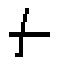

***************
Box: 
ymin:  0.4339892  xmin:  0.44135696  ymax:  0.54015577  xmax  0.5186095
left:  141.23422622680664  right:  165.95504760742188  top:  138.87654304504395  bottom  172.84984588623047
Top left point: ( 141 ,  138 ) and Bottom right point: ( 165 ,  172 )
CNN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 34.15 %
Symbol_id: 60 , Latex: y , Confidence Score: 26.09 %
Symbol_id: 24 , Latex: Y , Confidence Score: 8.48 %
Symbol_id: 25 , Latex: Z , Confidence Score: 5.83 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 5.3 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.04 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.41 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.32 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.82 %


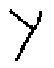

***************
Box: 
ymin:  0.44970995  xmin:  0.84640485  ymax:  0.51833904  xmax  0.95808643
left:  270.849552154541  right:  306.5876579284668  top:  143.90718460083008  bottom  165.86849212646484
Top left point: ( 270 ,  143 ) and Bottom right point: ( 306 ,  165 )
CNN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 71.02 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.56 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 6.16 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.82 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.48 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.02 %


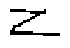

***************
Box: 
ymin:  0.45574093  xmin:  0.6282596  ymax:  0.51013386  xmax  0.7029208
left:  201.04307174682617  right:  224.93465423583984  top:  145.83709716796875  bottom  163.24283599853516
Top left point: ( 201 ,  145 ) and Bottom right point: ( 224 ,  163 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 50.66 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 10.03 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 9.4 %
Symbol_id: 94 , Latex: \div , Confidence Score: 7.3 %
Symbol_id: 105 , Latex: //( , Confidence Score: 4.75 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.07 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.97 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.44 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.25 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.14 %


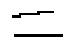

***************
Box: 
ymin:  0.43925992  xmin:  0.022735465  ymax:  0.54577696  xmax  0.10554019
left:  7.275348901748657  right:  33.77286195755005  top:  140.56317329406738  bottom  174.64862823486328
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.49 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.46 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.48 %


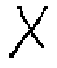

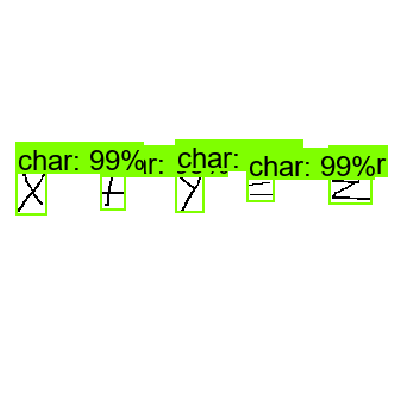

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp7.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44655743  xmin:  0.2437716  ymax:  0.5314337  xmax  0.31228882
left:  78.006911277771  right:  99.93242263793945  top:  142.89837837219238  bottom  170.05878448486328
Top left point: ( 78 ,  142 ) and Bottom right point: ( 99 ,  170 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 31.57 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 19.09 %
Symbol_id: 42 , Latex: f , Confidence Score: 18.22 %
Symbol_id: 94 , Latex: \div , Confidence Score: 11.54 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 7.02 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.05 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.75 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.47 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.17 %
Symbol_id: 54 , Latex: r , Confidence Score: 1.07 %


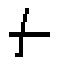

***************
Box: 
ymin:  0.42436662  xmin:  0.45109984  ymax:  0.5368087  xmax  0.5025804
left:  144.35194969177246  right:  160.8257293701172  top:  135.79731941223145  bottom  171.77879333496094
Top left point: ( 144 ,  135 ) and Bottom right point: ( 160 ,  171 )
CNN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 89.15 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.4 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.34 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.35 %


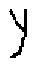

***************
Box: 
ymin:  0.45547962  xmin:  0.6287612  ymax:  0.51028204  xmax  0.70908487
left:  201.20357513427734  right:  226.90715789794922  top:  145.75347900390625  bottom  163.29025268554688
Top left point: ( 201 ,  145 ) and Bottom right point: ( 226 ,  163 )
CNN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 29.03 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 18.03 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 13.31 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 5.19 %
Symbol_id: 105 , Latex: //( , Confidence Score: 5.18 %
Symbol_id: 94 , Latex: \div , Confidence Score: 5.06 %
Symbol_id: 104 , Latex: = , Confidence Score: 4.61 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.88 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.77 %
Symbol_id: 100 , Latex: ] , Confidence Score: 1.59 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.28 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.1 %
Symbol_id: 4 , Latex: E , Confidence Score: 1

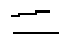

***************
Box: 
ymin:  0.44975138  xmin:  0.84644526  ymax:  0.5183056  xmax  0.958083
left:  270.8624839782715  right:  306.58655166625977  top:  143.92044067382812  bottom  165.85779190063477
Top left point: ( 270 ,  143 ) and Bottom right point: ( 306 ,  165 )
CNN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 71.02 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.56 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 6.16 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.82 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.48 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.02 %


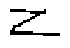

***************
Box: 
ymin:  0.4392186  xmin:  0.022519318  ymax:  0.54599553  xmax  0.10571112
left:  7.206181883811951  right:  33.82755756378174  top:  140.549955368042  bottom  174.71857070922852
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.49 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.46 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.48 %


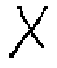

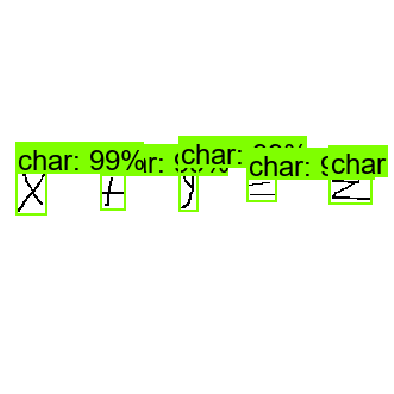

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp8.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44656202  xmin:  0.2437685  ymax:  0.5314334  xmax  0.31224176
left:  78.00591945648193  right:  99.9173641204834  top:  142.89984703063965  bottom  170.05868911743164
Top left point: ( 78 ,  142 ) and Bottom right point: ( 99 ,  170 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 31.57 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 19.09 %
Symbol_id: 42 , Latex: f , Confidence Score: 18.22 %
Symbol_id: 94 , Latex: \div , Confidence Score: 11.54 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 7.02 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.05 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.75 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.47 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.17 %
Symbol_id: 54 , Latex: r , Confidence Score: 1.07 %


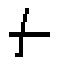

***************
Box: 
ymin:  0.42476645  xmin:  0.44477567  ymax:  0.53971493  xmax  0.50261307
left:  142.32821464538574  right:  160.836181640625  top:  135.9252643585205  bottom  172.70877838134766
Top left point: ( 142 ,  135 ) and Bottom right point: ( 160 ,  172 )
CNN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 95.98 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.88 %


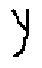

***************
Box: 
ymin:  0.4524996  xmin:  0.63820094  ymax:  0.5037509  xmax  0.71529585
left:  204.22430038452148  right:  228.89467239379883  top:  144.79987144470215  bottom  161.2002944946289
Top left point: ( 204 ,  144 ) and Bottom right point: ( 228 ,  161 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 34.77 %
Symbol_id: 79 , Latex: > , Confidence Score: 16.88 %
Symbol_id: 94 , Latex: \div , Confidence Score: 8.68 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.96 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 4.45 %
Symbol_id: 104 , Latex: = , Confidence Score: 4.11 %
Symbol_id: 106 , Latex: //) , Confidence Score: 3.37 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.55 %
Symbol_id: 105 , Latex: //( , Confidence Score: 2.48 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.27 %
Symbol_id: 83 , Latex: - , Confidence Score: 2.18 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.06 %


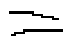

***************
Box: 
ymin:  0.44378754  xmin:  0.8446104  ymax:  0.51995987  xmax  0.9567364
left:  270.2753257751465  right:  306.15564346313477  top:  142.0120143890381  bottom  166.38715744018555
Top left point: ( 270 ,  142 ) and Bottom right point: ( 306 ,  166 )
CNN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 69.72 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 12.43 %
Symbol_id: 25 , Latex: Z , Confidence Score: 9.88 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.35 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.38 %


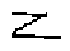

***************
Box: 
ymin:  0.4392186  xmin:  0.022519315  ymax:  0.54599553  xmax  0.10571112
left:  7.206180691719055  right:  33.82755756378174  top:  140.549955368042  bottom  174.71857070922852
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.49 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.46 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.48 %


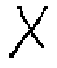

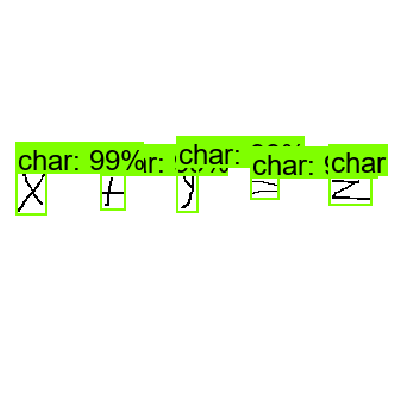

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp9.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.42423746  xmin:  0.4453438  ymax:  0.5399972  xmax  0.5036146
left:  142.51001358032227  right:  161.15667343139648  top:  135.7559871673584  bottom  172.79911041259766
Top left point: ( 142 ,  135 ) and Bottom right point: ( 161 ,  172 )
CNN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 92.57 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.87 %


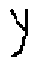

***************
Box: 
ymin:  0.44657612  xmin:  0.2300403  ymax:  0.5237957  xmax  0.29843682
left:  73.61289501190186  right:  95.49978256225586  top:  142.90435791015625  bottom  167.61463165283203
Top left point: ( 73 ,  142 ) and Bottom right point: ( 95 ,  167 )
CNN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 86.45 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 8.89 %


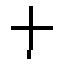

***************
Box: 
ymin:  0.45239803  xmin:  0.6390137  ymax:  0.5036976  xmax  0.7168195
left:  204.4843864440918  right:  229.3822479248047  top:  144.76737022399902  bottom  161.18322372436523
Top left point: ( 204 ,  144 ) and Bottom right point: ( 229 ,  161 )
CNN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 34.77 %
Symbol_id: 79 , Latex: > , Confidence Score: 16.88 %
Symbol_id: 94 , Latex: \div , Confidence Score: 8.68 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.96 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 4.45 %
Symbol_id: 104 , Latex: = , Confidence Score: 4.11 %
Symbol_id: 106 , Latex: //) , Confidence Score: 3.37 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.55 %
Symbol_id: 105 , Latex: //( , Confidence Score: 2.48 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.27 %
Symbol_id: 83 , Latex: - , Confidence Score: 2.18 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.06 %


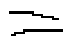

***************
Box: 
ymin:  0.43931293  xmin:  0.02323967  ymax:  0.54628336  xmax  0.10514064
left:  7.436694502830505  right:  33.645005226135254  top:  140.58013916015625  bottom  174.81067657470703
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.49 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.46 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.48 %


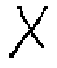

***************
Box: 
ymin:  0.44205776  xmin:  0.858077  ymax:  0.52738947  xmax  0.9661817
left:  274.5846366882324  right:  309.1781425476074  top:  141.45848274230957  bottom  168.76462936401367
Top left point: ( 274 ,  141 ) and Bottom right point: ( 309 ,  168 )
CNN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 38.18 %
Symbol_id: 61 , Latex: z , Confidence Score: 26.58 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 6.7 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 5.49 %
Symbol_id: 78 , Latex: < , Confidence Score: 4.54 %
Symbol_id: 105 , Latex: //( , Confidence Score: 4.0 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.69 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.2 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.15 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.08 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.02 %


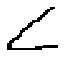

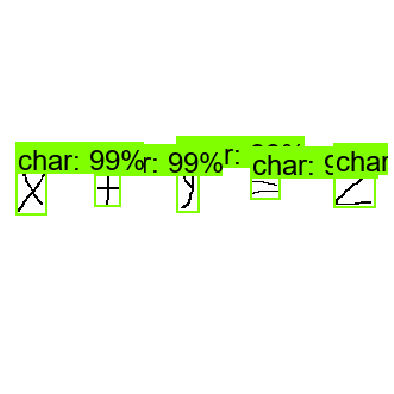

In [11]:
for image_path in TEST_IMAGE_PATHS:
    image_path = image_path.replace("\\", "/")
    im_name = image_path.split("/")[-1]
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    if len(image_np.shape) < 3:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    else:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    print('-'*25)
    print('Detecting Boxes for Image: ', image_path)
    print('Image shape: ', image_np.shape)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    # Visualization of the results of a detection.
    """
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    """
    # cv2.imshow('scene', image_np)
    # plt.show()

    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.array([output_dict['detection_boxes'][i]]),
                np.array([output_dict['detection_classes'][i]]),
                np.array([output_dict['detection_scores'][i]]),
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=2)
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width,
                                          xmax * im_width,
                                          ymin * im_height,
                                          ymax * im_height)
            print('*'*15)
            print("Box: ")
            print("ymin: ", ymin," xmin: ", xmin, " ymax: ", ymax," xmax ", xmax)
            print("left: ", left," right: ", right," top: ", top," bottom ", bottom)
            print("Top left point: (",int(left),", ",int(top),") and Bottom right point: (",int(right),", ",int(bottom),")")
            
            cropped_image = image.crop((left, top, right, bottom))
            
            # Predict label for cropped image with CNN
            c_im = np.asarray(cropped_image)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_BGRA2RGBA)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2RGB)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2GRAY)
            c_im = cv2.resize(c_im, (32,32))
            c_im = np.resize(c_im, (1, 1, 32, 32))
            c_im = c_im / 255.0
            res = cnn.predict(c_im)
            res = res.flatten()
            # lbl = one_hot_encode_to_char(res, threshold=0.1)
            # if type(lbl) == list: lbl = lbl[0]
            # print("Symbol is :", symbols.loc[symbols['new_id']==lbl])
            lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
            print("CNN Predictions:")
            for j in lbls:
                symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
                latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
                print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')
            plt.figure(figsize=(1,1))
            plt.axis('off')
            plt.imshow(np.asarray(cropped_image))
            plt.show()
            cropped_images.append(np.asarray(cropped_image))
            #cv2.imshow('model', np.asarray(cropped_image))
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(cv2.resize(image_np, (int(im_width), int(im_height))))
    plt.show()
    #cv2.imshow(im_name, cv2.resize(image_np, (int(im_width), int(im_height))))
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
